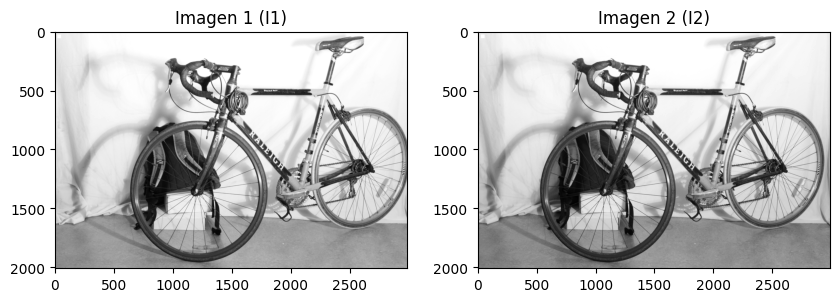

KeyboardInterrupt: 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Definir parámetros genéricos para el algoritmo
f = 1.0  # Distancia focal (genérica)
delta_x = 1.0  # Distancia entre planos de imagen

# Crear imágenes de prueba genéricas
img1 = cv2.imread("images/im0.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("images/im1.png", cv2.IMREAD_GRAYSCALE)

# Añadir patrones simples para simular imágenes estéreo
cv2.rectangle(img1, (20, 30), (50, 60), 255, -1)
cv2.rectangle(img2, (25, 30), (55, 60), 255, -1)

# Mostrar imágenes iniciales
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1, cmap='gray')
axs[0].set_title("Imagen 1 (I1)")
axs[1].imshow(img2, cmap='gray')
axs[1].set_title("Imagen 2 (I2)")
plt.show()

# Implementar el algoritmo compute_depth
def compute_depth(I1, I2, delta_x, f):
    depth = np.zeros_like(I1, dtype=np.float32)
    height, width = I1.shape
    for j in range(height):
        for i in range(width):
            fij = I1[j, i]
            best_score = float('inf')
            best_i = None
            for i_prime in range(width):
                fi_prime_j = I2[j, i_prime]
                score = abs(int(fij) - int(fi_prime_j))  # Métrica de similitud simple
                if score < best_score:
                    best_score = score
                    best_i = i_prime
            if best_i is not None and i != best_i:
                depth[j, i] = f * delta_x / abs(i - best_i)
    return depth

# Calcular profundidad utilizando el algoritmo genérico
depth_map_stereo = compute_depth(img1, img2, delta_x, f)

# Mostrar el mapa de profundidad obtenido
plt.figure(figsize=(6, 6))
plt.imshow(depth_map_stereo, cmap='jet')
plt.colorbar(label="Profundidad (unidades arbitrarias)")
plt.title("Mapa de profundidad - Algoritmo PDF")
plt.show()

# Cargar modelo MiDaS para comparación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small", trust_repo=True)
midas.to(device).eval()

# Transformaciones para el modelo MiDaS
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True).small_transform

# Crear una imagen monocular para MiDaS
img_midas = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
input_batch = midas_transforms(Image.fromarray(img_midas)).to(device)

# Estimar la profundidad con MiDaS
with torch.no_grad():
    prediction = midas(input_batch)
    depth_map_midas = prediction.squeeze().cpu().numpy()

# Mostrar el mapa de profundidad generado por MiDaS
plt.figure(figsize=(6, 6))
plt.imshow(depth_map_midas, cmap='jet')
plt.colorbar(label="Profundidad estimada")
plt.title("Mapa de profundidad - MiDaS")
plt.show()
